# Topic Analysis

In this notebook, I will use the official press releases in French by the Federal Council ([collected from here](https://www.admin.ch/gov/fr/accueil/documentation/communiques/communiques-conseil-federal.html?dyn_startDate=01.01.2015&dyn_pageIndex=1)). For this analysis, I collected only press releases, including the term "Coronavirus" in their title. The dataset is available in the `/data` folder.

*Note: The press releases date from the end of February 2020 until mid-February 2021.*

My goal is to explore the *main topics* or *underlying ideas* in each press release in the corpus. In this particular corpus about the Coronavirus epidemic, possible *topics* could be, for example, "establishing border controls", "banning gatherings and large scale events", or "providing financial assistance to companies". I explore different techniques such as word frequencies, weighted word frequencies and latent semantic analysis (PCA).

Here are the steps that I will go through in this notebook:
1. Text cleaning using spaCy
2. Topic Analysis
    * Word frequencies 
    * Weighted word frequencies (tf-idf)
    * Latent Semantic Analysis (PCA)
4. Topic evolution over time

In [1]:
# Import libraries

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, random
from collections import defaultdict, Counter
import nltk
#import tools

# Gensim
import gensim
from gensim.models import Phrases

# Wordcloud
from wordcloud import WordCloud

#pd.set_option('display.max_colwidth',1500)

import matplotlib.cm as cm
color_1 = cm.get_cmap("Set2")(2) # blue color
color_2 = cm.get_cmap("Set2")(1) # orange color

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run tools

In [2]:
# Path to data folder

DATA_PATH = './data'

In [3]:
# Load press releases (in French)

path = os.path.join(DATA_PATH,'communiques_conseil_federal.csv')
df = pd.read_csv(path)

# Remove rows with missing values
df.dropna(inplace=True)

print('Data size: ',df.shape)

Data size:  (137, 4)


Our corups has 137 documents.

In [4]:
# Show a few samples

with pd.option_context('display.max_colwidth', 500):
    display(df.sample(3))

,title,url,pub_date,text
22,Coronavirus : Indemnités en cas de réduction de l’horaire de travail : prolongation à 18 mois,https://www.admin.ch/gov/fr/accueil/documentation/communiques.msg-id-79716.html,2020-07-01,"Berne, 01.07.2020 - Le 1er juillet 2020, le Conseil fédéral a prolongé la durée d’indemnisation en cas de réduction de l’horaire de travail (RHT), qui passe de 12 à 18 mois. Parallèlement, le délai de carence est fixé à 1 jour. La modification d’ordonnance entre en vigueur le 1er septembre 2020 et s’applique jusqu’au 31 décembre 2021. La prolongation de la durée maximale des indemnités journalières à 18 mois à partir du 1er septembre 2020 permet aux entreprises et aux employés concernés de c..."
62,Coronavirus : suspension temporaire des intérêts moratoires sur les arriérés de cotisation,https://www.admin.ch/gov/fr/accueil/documentation/communiques.msg-id-78931.html,2020-04-29,"Berne, 29.04.2020 - Lors de sa séance du 29 avril 2020, le Conseil fédéral a décidé que, pendant la situation extraordinaire due au coronavirus, les intérêts moratoires sur les arriérés de cotisations AVS/AI/APG et AC ne seraient pas exigés. Cette réglementation temporaire complète la mesure déjà prise en matière de suspension des intérêts lors de sursis de paiement accordés aux entreprises manquant de liquidités. Les assurances sociales AVS/AI/APG ainsi que l’assurance-chômage (AC) sont fin..."
123,"Coronavirus : le Conseil fédéral renforce les mesures nationales et ferme les restaurants, les établissements culturels et sportifs ainsi que les lieux de loisirs",https://www.admin.ch/gov/fr/accueil/documentation/communiques.msg-id-81745.html,2020-12-18,"Berne, 18.12.2020 - La situation épidémiologique est préoccupante. Le nombre de contaminations est très élevé et augmente à nouveau. Les hôpitaux et le personnel soignant sont surchargés depuis des semaines, et les fêtes qui approchent renforcent le risque de propagation accélérée du virus. Lors de sa séance du 18 décembre 2020, le Conseil fédéral a donc décidé, après avoir consulté les cantons, de renforcer les mesures nationales visant à endiguer la pandémie. L’objectif est de réduire fort..."


We have the title, the URL, the publication date, and the actual text for each press release. I will only need the `pub_date`, the `title` and the `text` columns later on (I will drop the other ones below). Moreover, I will arrange the documents in chronological order. This way, later in the exercise, I can analyze how the documents' topics evolved over time.

In [5]:
# Keep only necessary columns
df = df[['pub_date','title', 'text']].copy()

# Sort documents by publication date
df.sort_values(by='pub_date',inplace=True, ignore_index=True)

print('Data: ',df.shape)

Data:  (137, 3)


We converted the column pub_date to datetime. Below, we see that the earliest press release is from February 28, 2020, and the last one from February 2, 2021.

In [6]:
# Print earliest publication date

df['pub_date'].min()

'2020-02-28'

In [7]:
# Print latest publication date

df['pub_date'].max()

'2021-02-17'

## Text cleaning

Text cleaning is essential for every NLP project. However, the documents in this corpus are official press releases, which will probably require less cleaning.

Moreover, the text is in French. Therefore, I will need NLP tools for French, such as stopwords lists and stemmers/lemmatizers. I will use [spaCy](https://spacy.io/); an open-source package supporting 69+ languages. It has many great functionalities, such as part-of-speech (POS) tagging, lemmatization, and precompiled stopwords lists.

Let's have a look at the "raw" text once more.

In [8]:
with pd.option_context('display.max_colwidth', 500):
    display(df.sample(3))

,pub_date,title,text
61,2020-05-20,Coronavirus: Aide immédiate temporaire en faveur des médias,"Berne, 20.05.2020 - La pandémie de coronavirus frappe durement les médias. Leurs recettes publicitaires ont déjà baissé drastiquement. Au vu de l'importance particulière des médias pour la démocratie, le Parlement a transmis, lors de la session extraordinaire, plusieurs motions largement soutenues demandant de fournir une aide financière immédiate d'un montant de 57.5 millions de francs. Lors de sa séance du 20 mai 2020, le Conseil fédéral a adopté deux ordonnances de nécessité en ce sens. E..."
31,2020-04-16,Coronavirus: le tourisme d&aposachat reste interdit,"Berne, 16.04.2020 - Lors de sa séance du 16 avril 2020, le Conseil fédéral a adopté des modifications et des précisions pour l'ordonnance 2 sur les mesures destinées à lutter contre le coronavirus (COVID-19). Ces modifications et précisions visent à éviter toute ambiguïté et tout malentendu et apportent des éclaircissements à la population. L'interdiction des voyages d'achat et les dispositions relatives aux amendes notamment sont explicitement réglées. Depuis la mi-mars, la Suisse a réintro..."
90,2020-07-01,Allocation Corona-perte de gain pour les indépendants : prolongation jusqu’au 16 septembre 2020,"Berne, 01.07.2020 - Le droit à l’allocation Corona-perte de gain pour les indépendants directement ou indirectement touchés par les mesures de lutte contre le coronavirus a été prolongé jusqu’au 16 septembre 2020. Les personnes salariées de leur propre entreprise actives dans le domaine de l’événementiel et qui sont dans une situation de rigueur pourront aussi toucher l’allocation Corona-perte de gain. C’est ce que le Conseil fédéral a décidé lors de sa séance du 1er juillet 2020. Il tient a..."


Below are a few ideas for cleaning:

* convert to lowercase
* remove the publication date from the beginning of each document (e.g. "Berne, 13.05.2020")
* remove months and day names 
* remove numbers (e.g.  5,2, 20 mai 2020, 12.06.2020 ...)
* remove stopwords
* remove punctuation
* apply lemmatization
* remove 1-character words
* remove adverbs.

I will use spaCy to remove stopwords, punctuation, and adverbs and to apply lemmatization. Let's explore all of this in a bit more detail.

In [9]:
# Import spacy
import spacy

# Load language model for French
nlp = spacy.load("fr_core_news_sm")

### Stopwords

In [10]:
# Check spaCy's stopwords

print(len(nlp.Defaults.stop_words))

print(nlp.Defaults.stop_words)

507
{'il', 'suffit', 'après', 'pres', 'celles-la', 'vôtres', 'c’', 'specifiques', 'relative', 'seront', 'lès', 'là', 'est', 'lui-meme', 'ceux', 'donc', 'anterieure', 'â', 'tres', 'bas', 'nul', 'sept', 'pouvait', 'allaient', 'avec', 'suit', 'as', 'différentes', 'cinquante', 'cinquantième', 'eux', 'sixième', 'devers', 'suivre', 'hem', "l'", 'nôtre', 'cependant', 'moi', 'restent', 'vingt', 'nombreux', 'cinq', 'quatre', 'entre', 'dix-sept', 'avoir', 'desormais', "s'", 'dits', 'comment', 'peuvent', 'voici', 'reste', 'auront', 'voilà', 'eh', 'dit', 'tellement', 'maintenant', 'mon', 'feront', 'semblent', 'y', 'rendre', 'seul', 'pas', 'suivant', 'n’', 'douze', 'telles', "qu'", 'anterieures', "j'", 'nouveau', 'semblaient', 'quiconque', 'o', 'premier', 'personne', 'aurait', 'tien', 'celui-là', 'malgré', 'anterieur', 'ceux-là', 'telle', 'douzième', 'jusqu', 'ce', 'celles-ci', 'antérieur', 'tente', 'nôtres', 'préalable', 'different', 'treize', 'deja', 'me', 'partant', 'lesquelles', "quelqu'un", 'l

### SpaCy's processing pipeline

Now, let's see how spaCy processes text.

To process text with spaCy, we need to call the `nlp` processing pipeline. Unlike NLTK, the `nlp` pipeline implements several useful NLP tools without calling on them individually. These tools include a tokenizer and a POS tagger. We can apply all of these tools with a single code line by calling the `nlp` pipeline. This process also ensures that each component's output is fed to the next one without taking care of the input-output formats.

<p align="center"><img src="data/spacy_pipeline.png" style="width:800px; height:170px;"></p>

<center>Source: https://spacy.io/usage/processing-pipelines</center>

In [11]:
# Test on a sample of text

text_sample = 'Le Conseil fédéral a encore renforcé les mesures de protection de la population au cours d’une séance extraordinaire.'

print('Before preprocessing:\n')
print(text_sample)

Before preprocessing:

Le Conseil fédéral a encore renforcé les mesures de protection de la population au cours d’une séance extraordinaire.


In [12]:
# Call nlp pipeline

doc = nlp(text_sample)

print(type(doc))

<class 'spacy.tokens.doc.Doc'>


The `nlp` pipeline starts by applying tokenization to this text to extract individual words: 

$$\text{["Le", "Conseil", "fédéral", "a", …]}$$ 

Then, the words are then passed to a POS tagger that assigns parts-of-speech tags to each word:  

$$\text{["DET", "NOUN", "ADJ", "AUX", …]}$$

...and then to a lemmatizer that produces an output like this: 

$$\text{["le", "conseil", "fédéral", "avoir", …]}$$

**Lemmatization**
    
paCy doesn't implement a stemmer in its processing pipeline but uses a lemmatizer. Lemmatization is the process of converting words to their "dictionary" form (*lemma*). Lemmatization may be preferable for topic analysis, as it produces interpretable "terms"; stemming can generate non-words.

In [13]:
# Show tokens and corresponding lemmas

for word in doc:
    print('({} , {}))'.format(word, word.lemma_))

(Le , le))
(Conseil , conseil))
(fédéral , fédéral))
(a , avoir))
(encore , encore))
(renforcé , renforcer))
(les , le))
(mesures , mesure))
(de , de))
(protection , protection))
(de , de))
(la , le))
(population , population))
(au , au))
(cours , cours))
(d’ , d’))
(une , un))
(séance , séance))
(extraordinaire , extraordinaire))
(. , .))


**POS-tags**

In Topic Analysis, we want to extract the main *ideas* and *concepts* in a corpus. In this respect, we expect *nouns* and *verbs* to convey more information about the underlying *themes* in the documents than adverbs or auxiliary verbs. With spaCy's pipeline, discarding specific parts-of-speech from the text (e.g. adverbs, auxiliary verbs, etc.) becomes easy.

In [14]:
# Show tokenization and POS-tagging

for word in doc:
    print('({} , {}))'.format(word, word.pos_))

(Le , DET))
(Conseil , NOUN))
(fédéral , ADJ))
(a , AUX))
(encore , ADV))
(renforcé , VERB))
(les , DET))
(mesures , NOUN))
(de , ADP))
(protection , NOUN))
(de , ADP))
(la , DET))
(population , NOUN))
(au , ADP))
(cours , NOUN))
(d’ , ADV))
(une , DET))
(séance , NOUN))
(extraordinaire , ADJ))
(. , PUNCT))


In [15]:
print('Before processing:\n')
print(text_sample)

# Remove adverbs, stopwords, punctuation and numbers
processed_tokens = [] # Empty list

# Remove stopwords, punctuation and numbers  - Append lemma
for word in doc:
    if not word.pos_ == 'ADV' and not word.pos_ == 'AUX' and not word.is_stop and not word.is_punct:
        processed_tokens.append(word.lemma_)

print('\nAfter processing:\n')
print(processed_tokens)

Before processing:

Le Conseil fédéral a encore renforcé les mesures de protection de la population au cours d’une séance extraordinaire.

After processing:

['conseil', 'fédéral', 'renforcer', 'mesure', 'protection', 'population', 'cours', 'séance', 'extraordinaire']


Now let's bring everything together with the `process_french_text` funchion which takes a sample of text as an argument and processes it.

In [16]:
# Define process_french_text

def process_french_text(text):
    
    '''
    Process raw samples of text using regular expressions and 
    spaCy's processing pipeline.
    
    INPUT: 
    - text: raw text (string)
    
    OUTPUT:
    - processed_tokens: list of processed tokens (list of strings)
    '''
    
    # Create empty list
    processed_tokens = []
    
    # Convert to lowercase
    text = text.lower()
    
    # Standardize "COVID 19", "COVID", "Covid-19" and "sars-cov-2" -> covid
    text = re.sub(r'\s"?covid[-\s]?19',r' covid',text)
    text = re.sub(r'\ssars-cov-2',' covid',text)
    
    # Remove "Berne, XX.XX.202X - " at the beginning of every press release
    text = re.sub(r'berne,\s[0-9]{2}.[0-9]{2}.202[01]\s?-?\s?','',text)
    
    # Standardize "afrique du sud" and "grande-bretagne"
    text = re.sub(r'afrique du sud','afrique_du_sud',text)
    text = re.sub(r'grande-bretagne','grande_bretagne',text)
    
    # Remove month and day names
    text = re.sub(r'(janvier|février|mars|avril|\bmai\b|juin|juillet|août|septembre|octobre|novembre|décembre)',' ',text)
    text = re.sub(r'(lundi|mardi|mercredi|jeudi|vendredi|samedi|dimanche)',' ',text)
        
    # Remove 1er e.g. in "1er juin"
    text = re.sub(r'\d+er','',text)
    
    # Remove numbers
    text = re.sub(r'\d+','',text)
    
    # Remove (very frequent) uniformative terms
    text = re.sub(r'karin keller-sutter','',text)
    text = re.sub(r'(\bséances?\b|\bapplicables?\b|\ba-t-il\b|\bjusqu’\b|\bh\.)','',text)
    text = re.sub(r"communiqué de presse disponible en tant que document pdf.",'',text)
    
    # Remove non-breaking and excessive whitespace
    text = text.replace(u'\xa0', u' ')
    text = re.sub(r'\s+',' ',text)
    
    # Implement spaCy's pipeline
    doc = nlp(text)
    
    # Remove Adverbs, auxiliary verbs, stopwords and punctuation
    for word in doc:
        if not word.pos_ == 'ADV' and not word.pos_ == 'AUX' and not word.is_stop and not word.is_punct:
            # Lemmatize token 
            processed_tokens.append(word.lemma_)
            
    # Remove single char tokens
    processed_tokens = [token for token in processed_tokens if len(token) > 1]
    
    return processed_tokens

Let's test this function with a few examples.

In [17]:
# Show on a sample

text_sample = df['text'].sample().values[0]

print('Before cleaning: \n\n{}\n'.format(text_sample[0:1200]))
print('After cleaning: \n\n{}\n'.format(process_french_text(text_sample)[0:100]))

Before cleaning: 

Berne, 20.03.2020 - Les défis de la pandémie actuelle touchent aussi le domaine judiciaire. Les tribunaux doivent cependant rester opérationnels pour assurer leurs fonctions essentielles. Afin de permettre aux tribunaux, aux autorités, aux procureurs, aux avocats et aux parties de mieux faire face aux difficultés causées par le coronavirus, le Conseil fédéral a décidé le 20 mars 2020 de faire débuter dès demain les féries judiciaires de Pâques en matière civile et administrative. Vu la situation extraordinaire en lien avec le coronavirus, le Conseil fédéral a fait usage de sa compétence pour prolonger les vacances des tribunaux, ou "féries judiciaires", situées normalement autour de Pâques, en matière civile et administrative, en les faisant commencer plus tôt. Elles dureront cette année du 21 mars au 19 avril compris. Le Conseil fédéral veut de la sorte permettre aux tribunaux de faire une pause pour s’adapter à cette période difficile. Tant les juridictions fédéral

### Collocations

There is one last thing we can do before moving on to exploring the topics in our documents. We can look for combinations of words that frequently appear together, such as: "Conseil fédéral", "assurance chômage", "loi covid", "chômage partiel", "transport public", etc. We often call these word combinations: phrases or collocations. These word combinations appear in texts more frequently than their constituent words appear individually.

We will use Gensim’s Phrases model to detect collocations in our corpus. model.phrases will identify the most common collocations and join the constituent tokens into a single token, using the “_” glue character.

In [18]:
%%time

# Process all press releases (and add to list)
processed_press_releases = [process_french_text(doc) for doc in df['text']]

# Detect word n-gram collocations in corpus

for i in ['bigrams']:
    print('Computing collocations ({})...'.format(i))
    
    bigram = gensim.models.Phrases(processed_press_releases,   # Expected format: list of tokenized documents
                                   min_count=5,                # Ignore all words and bigrams with total collected count lower than this value.
                                   delimiter=b'_')             # Glue character used to join collocation tokens

    bigram_model = gensim.models.phrases.Phraser(bigram)

    # Add detected collocations to corpus
    processed_press_releases = [bigram_model[doc] for doc in processed_press_releases]
    print('Done!')
    
# Add processed text to dataframe
df['processed_text'] = processed_press_releases

# Wall time: ~17 s

Computing collocations (bigrams)...
Done!
CPU times: user 14.6 s, sys: 1.56 s, total: 16.2 s
Wall time: 16.3 s


In [19]:
# Show on a randomly sampled document

# Generate random document index
rnd_idx = random.randint(0,len(df)-1)
print('Document number: {}\n'.format(rnd_idx))

text_sample = df.iloc[rnd_idx]['text']

print('Before processing: \n\n{}\n'.format(text_sample[0:1200]))
print('After processing: \n\n{}\n'.format(processed_press_releases[rnd_idx][0:100]))

Document number: 54

Before processing: 

Berne, 13.05.2020 - Lors de sa réunion du 13 mai 2020, le Conseil fédéral a fixé les domaines bénéficiant des mesures de stabilisation ainsi que les critères financiers prévus pour le sport suisse. Pour les ligues de football et de hockey sur glace, 350 millions de francs seront mis à disposition. En ce qui concerne le sport populaire et d’élite, la somme s’élève à 150 millions de francs. Des associations locales aux clubs et formations professionnels, nombreuses sont les figures du monde sportif suisse qui sont menacées par la paralysie de la vente des billets et des abonnements, par l’annulation de manifestations sportives, de grande comme de petite envergure, ou encore par le retrait des sponsors. L’expérience que nous avons acquise depuis les crises financières et économiques du passé nous a montré que le sport est généralement plus touché que l’économie, et de façon plus durable. Ce constat se fonde sur les mécanismes de financement propre

Let's find out which are the most common collocations in the corpus!

In [20]:
# Map collocations to their frequency using dictionaries

# Create an empty dictionary  
collocations_dict = defaultdict(int)  

for doc in processed_press_releases:  
    for word in doc: 
        if '_' in word:  # Look for tokens separated by '_' : these are collocations!
            collocations_dict[word] +=1  # Update counts  
            
# Sort counts in descending order  
collocations_dict = {k:v for k,v in sorted(collocations_dict.items(),   
                                           key=lambda item:item[1], reverse=True)}  
  
print('Total number of collocations detected in corpus: {}'.format(len(list(collocations_dict.keys()))))  

Total number of collocations detected in corpus: 631


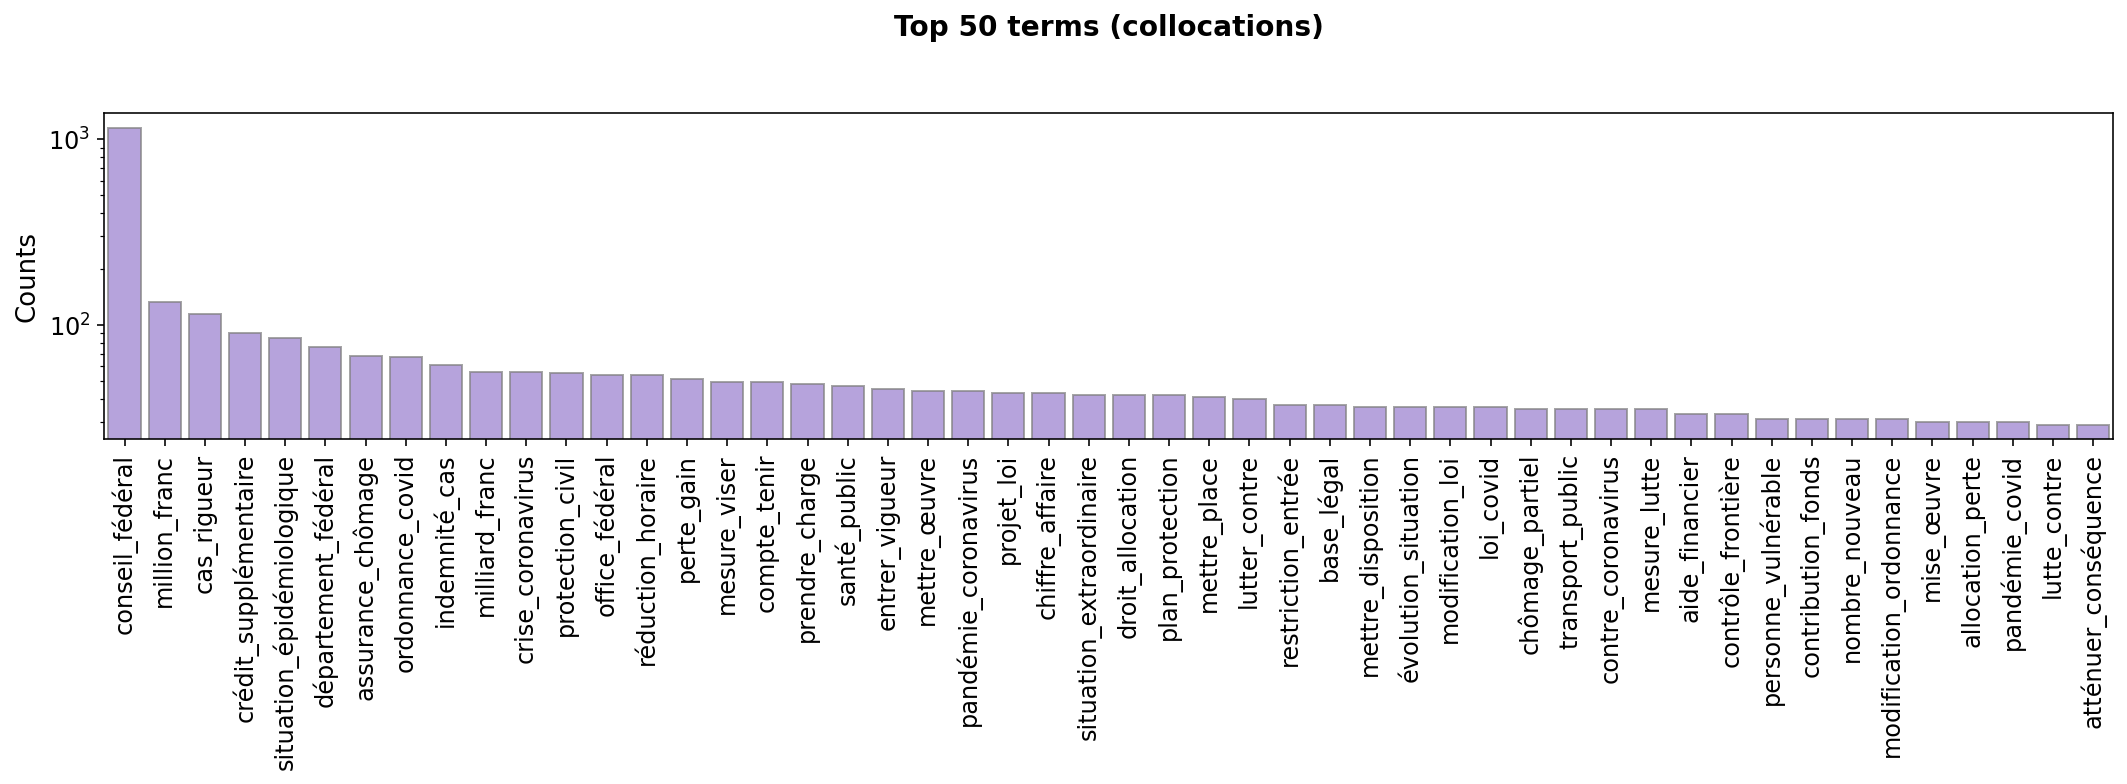

In [21]:
# Plot most frequent collocations in corpus  
plot_most_frequent_terms(collocations_dict, 50, add_to_title='(collocations)')  

Some interesting collocations:

* 'million_franc'
* 'crédit_supplémentaire'
* 'situation_épidémiologique'
* 'assurance_chômage'
* 'ordonnance_covid'
* 'indemnité_cas'
* 'réduction_horaire'
* 'perte_gain'
* 'santé_public'
* 'situation_extraordinaire'
* 'restriction_entrée'
* 'chômage_partiel'
* 'aide_financier'
* 'droit_indemnité'
* 'état_schengen'
* 'port_masque'
* 'nouveau_souche'
* 'suspension_poursuite'
* 'traçage_contact'
* 'test_rapide'
* 'difficulté_financier',
* ...

Most of the collocations point to the consequences (financial, epidemiological, ...) of the epidemic. 

We got a first good idea about the underlying topics in the corpus!

## Keyphrase extraction

Keyphrase extraction is a simple approach to topic analysis. It involves extracting the most common words and phrases and checking whether they capture underlying concepts or themes in a document or corpus. 

We will explore following approaches:
* word frequencies
* weighted word frequencies.

### Word frequences

We can also look at the most frequent words in a single document.

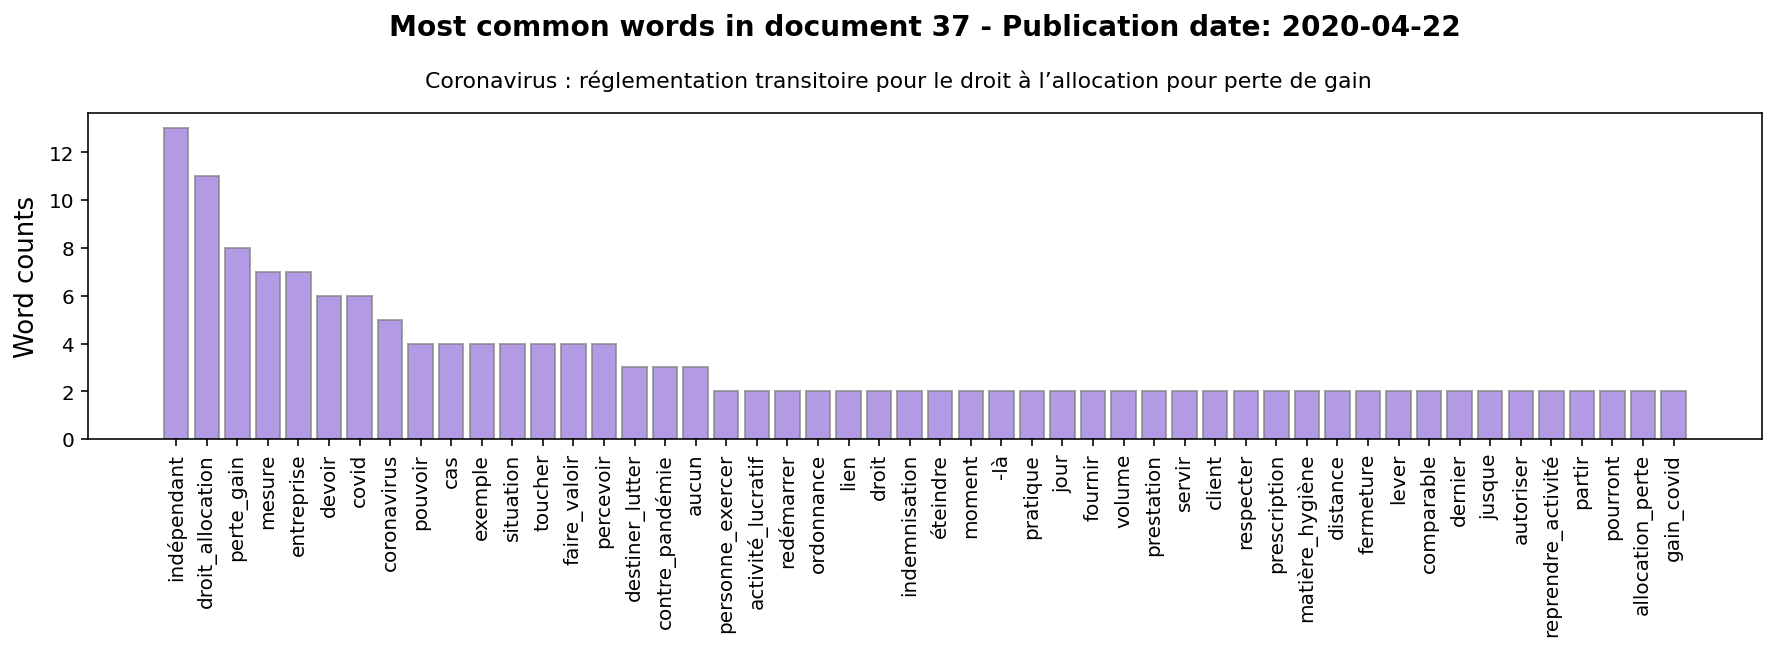

In [41]:
# Generates a random integer between 0 and len(df)
rnd_idx = random.randint(0,len(df)-1)

# Find top-50 most common words

w = Counter(df['processed_text'].iloc[rnd_idx]).most_common(50)

# Plots top words

# Barplot and font specifications
barplot_specs   = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
title_specs     = {"fontsize": 14, "fontweight": "bold", "y": 1.2}
suptitle_specs  = {"fontsize": 11}
label_specs     = {"fontsize": 13}

plt.figure(figsize=(15,3))
plt.bar(*zip(*w), **barplot_specs)
plt.title('Most common words in document {} - Publication date: {}'.format(rnd_idx,df.iloc[rnd_idx,0]), **title_specs)
plt.suptitle(df.iloc[rnd_idx,1],**suptitle_specs)
plt.ylabel('Word counts', **label_specs)
plt.xticks(rotation=90)
plt.show()

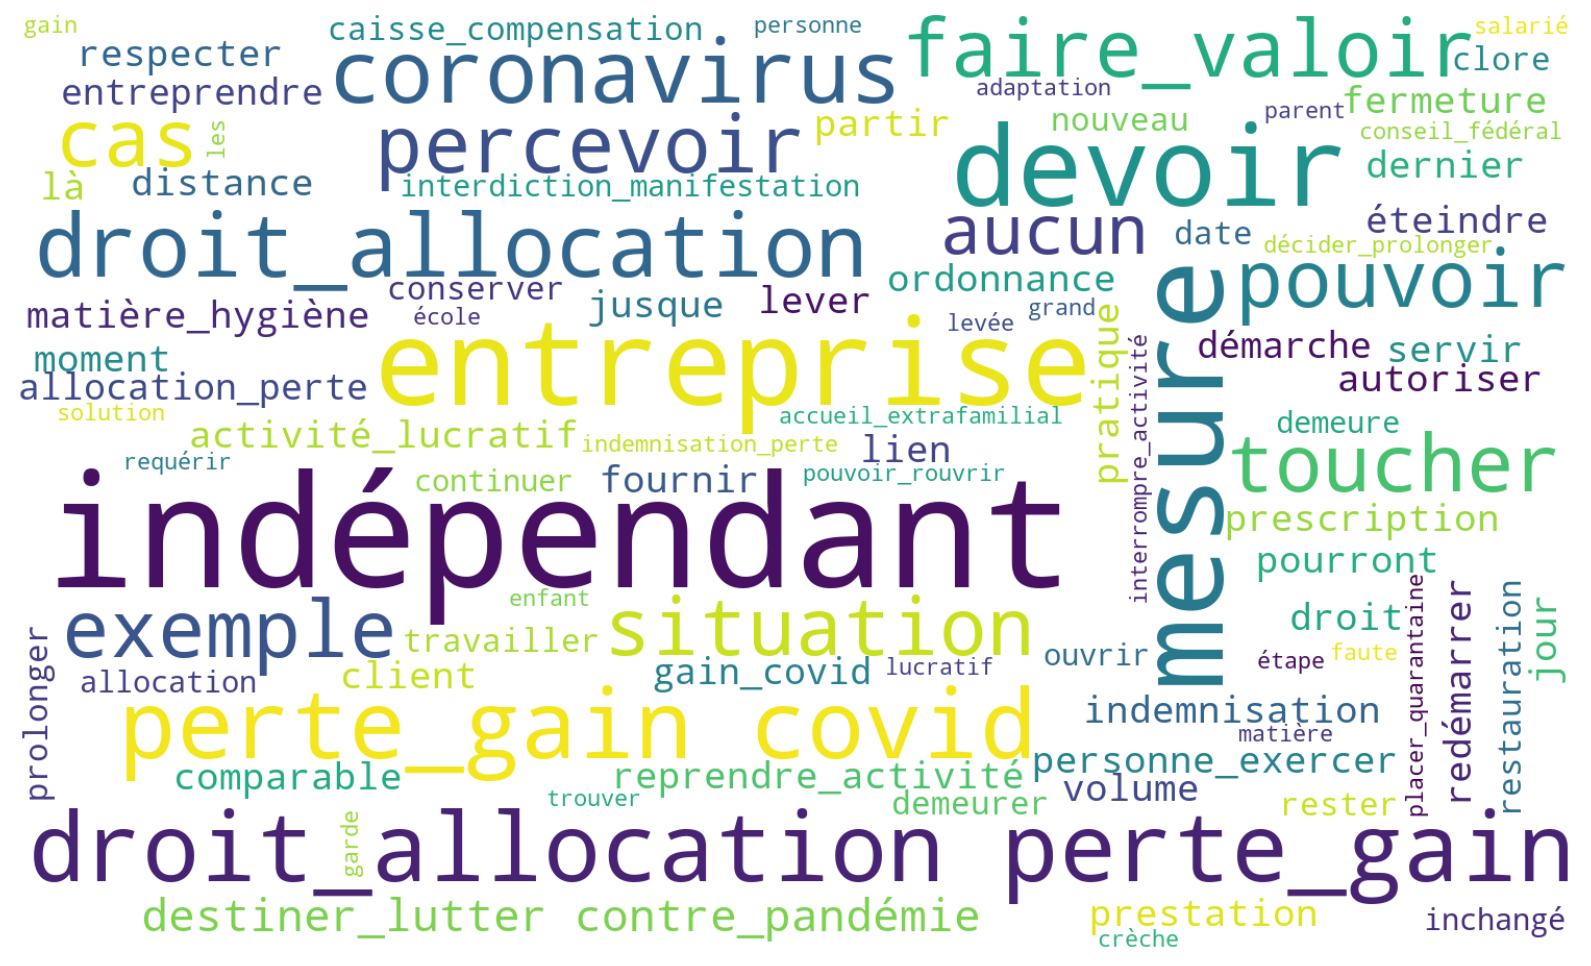

In [42]:
# Wordcloud

# Combine processed tokens in a single string
processed_sample = df['processed_text'].iloc[rnd_idx]
processed_sample_combined = ' '.join(processed_sample)

wordcloud = WordCloud(width=1500, height=900, random_state=0,max_words=300,
                      max_font_size=150, background_color="white").generate(processed_sample_combined)

plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear") # Interpolation: makes image smoother
plt.axis('off')
plt.show()

## Tf-idf weighting model : Weighted word frequencies

So far, we focused on raw word counts. However, the most frequent words in a document aren't necessarily the most informative and could be shadowing other rarer yet more interesting terms. We will now re-weight word frequencies using the *inverse term frequency or idf* from the Tf-idf model. 

We will implement the *Tf-idf* algorithm with the *TfidfVectorizer* object from [*scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

In [43]:
with pd.option_context('display.max_colwidth', 500):
    display(df.sample())

,pub_date,title,text,processed_text
122,2020-12-18,"Coronavirus : le Conseil fédéral renforce les mesures nationales et ferme les restaurants, les établissements culturels et sportifs ainsi que les lieux de loisirs","Berne, 18.12.2020 - La situation épidémiologique est préoccupante. Le nombre de contaminations est très élevé et augmente à nouveau. Les hôpitaux et le personnel soignant sont surchargés depuis des semaines, et les fêtes qui approchent renforcent le risque de propagation accélérée du virus. Lors de sa séance du 18 décembre 2020, le Conseil fédéral a donc décidé, après avoir consulté les cantons, de renforcer les mesures nationales visant à endiguer la pandémie. L’objectif est de réduire fort...","[situation_épidémiologique, préoccupant, nombre, contamination_élevé, augmente, hôpital, personnel_soigner, surcharger, semaine, fête, approcher, risque, propagation, accélérer, virus, conseil_fédéral, décider, consulter_canton, renforcer, mesure, national, viser, endiguer, pandémie, objectif, réduire_nombre, contact, interpersonnel, partir, restaurant_établissement, culturel, sportif, lieu, loisir, devoir, fermer_porte, conseil_fédéral, décider, élargir, utilisation, test_rapides, pouvoir, ..."


In [44]:
# Tf-idf expects lists of non-tokenized documents

X = [' '.join(doc) for doc in df['processed_text']]

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 2)  # Remove words appearing only once in the corpus

# X_tfidf: the tf-idf representation of the documents
X_tfidf = tfidf.fit_transform(X)

# Create tfidf vocabulary
tfidf_vocab = tfidf.get_feature_names()
print('Vocabulary size: {}\n'.format(len(tfidf_vocab)))
print(tfidf_vocab[0:500:10])

Vocabulary size: 2608

['abaisse', 'accepter', 'accorder_prêt', 'achever', 'actif_niveau', 'ad_hoc', 'admission', 'aff', 'agence_voyage', 'aider', 'allemagne_autriche', 'allouer', 'amortir', 'animation', 'apg', 'apport', 'approuver', 'arrivée', 'aspect', 'association', 'assurance_chômage', 'attente', 'atténuer_conséquence', 'automn', 'autorité_civil', 'aviation', 'aérien', 'banque_national', 'bibliothèque', 'bon_fonctionnement', 'bureaucratique', 'caduc', 'candidat', 'capacité', 'casino', 'cdip', 'cercle_bénéficiaire', 'chancellerie', 'chaîne', 'chute', 'cio', 'clarifier', 'coiffure', 'commerce_détail', 'compagnie_aérien', 'compléter_budget', 'compétition_sportif', 'concordataire', 'confier', 'conférence_directrice']


We can check what X_tfidf looks like using the following code snippet.

In [45]:
# Show Tf-idf words vectors
df_tfidf = pd.DataFrame(X_tfidf.toarray(),columns=tfidf_vocab)
df_tfidf.index = ['doc_'+str(i) for i in range(0,len(df_tfidf))]

# Show a few rows
df_tfidf.head()

,abaisse,abaisser,abandonner,abonnement,abroger,absence,absolu,abus,ac,acceptation,...,évolution,évolution_favorable,évolution_situation,évolution_épidémie,évolution_épidémiologique,évènement,événement,événementiel,être,œuvre
doc_0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.139525,0.0,0.0,0.00000,0.0,0.0,0.0
doc_1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.042821,0.0,0.000000,0.000000,0.0,0.0,0.04741,0.0,0.0,0.0
doc_2,0.0,0.039705,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.030286,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0
doc_3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.106029,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0
doc_4,0.0,0.000000,0.0,0.0,0.0,0.0,0.083274,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0


The tf-Idf model has converted each document to a list of tf-idf scores. Each row corresponds to a document from the corpus. For example, the third press release is represented by this list of numbers: [0., 0.03970463, 0., ..., 0., 0., 0.]. Note that tf-idf results in long vectors that are sparse (mostly filled with zeros).

## Top words according to tf-idf scores

Instead of looking at the topmost frequent words in each press release, we will focus on words with the highest tf-idf scores in each document. Remember, tf-idf favors words that are frequent in few press releases. We hope that this way, the importance of widespread words across all press releases (such as “Federal Council”, etc.) will be diminished, letting us focus on other more informative words about the content of individual press releases.

Below we plot the top 50 words according to the tf-idf scores.

In [46]:
# Generate random document index
#rnd_idx = random.randint(0,len(df)-1)
print('Document number: {} - Publication date: {}\n'.format(rnd_idx,df['pub_date'].iloc[rnd_idx]))

processed_sample = df['processed_text'].iloc[rnd_idx]

# Find top-weighted terms
words_sorted, weights_sorted = sort_words_by_weight(X_tfidf, tfidf_vocab, rnd_idx)

# Create tfidf dictionary (for plotting)
words_to_tfidf_dict = defaultdict(int,{key:value for (key,value) in zip(words_sorted,weights_sorted)})

Document number: 37 - Publication date: 2020-04-22



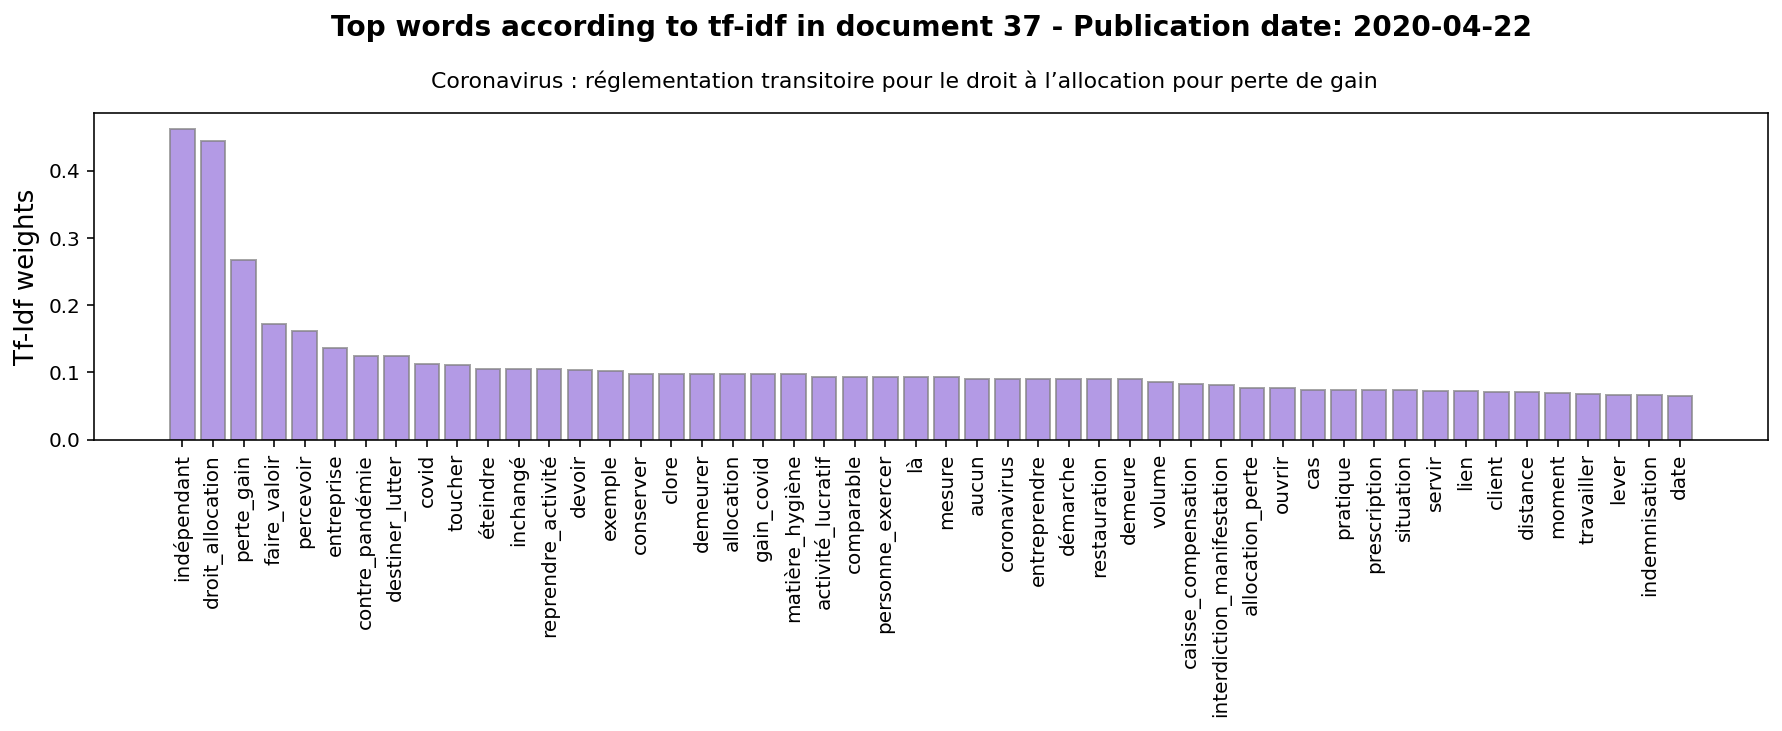

In [47]:
# Plots top words according to tf-idf scores

plt.figure(figsize=(15,3))
plt.bar(x = words_sorted[0:50],
        height=weights_sorted[0:50],
        **barplot_specs)

plt.title('Top words according to tf-idf in document {} - Publication date: {}'.format(rnd_idx,df.iloc[rnd_idx,0]), **title_specs)
plt.suptitle(df.iloc[rnd_idx,1],**suptitle_specs)
plt.ylabel('Tf-Idf weights', **label_specs)
plt.xticks(rotation=90)
plt.show()

## Latent Semantic Analysis (PCA)

PCA is generally used to compress data into fewer dimensions. Of course, it doesn't "understand" what topics are or what each word means. However, when it sees words such as: "entreprise", "crédit"', "aide", "milliard", etc. appear together a lot in texts, then it groups them. PCA will group terms that appear a lot together in a document and in the corpus (these terms have a high correlation with each other). Instead of keeping one dimension per term, PCA is "compactifying" the data by grouping correlated terms in a new single direction. These new directions are (linear) combinations of words, and we can think of them as "topics".

In [29]:
# PCA works better if the features are de-meaned

X_demeaned = X_tfidf - X_tfidf.mean(axis=0)

print(X_demeaned.shape)

(137, 2608)


In [30]:
# Apply PCA

from sklearn.decomposition import PCA
pca = PCA()

# Compute principal components
pca.fit(X_demeaned)

# Project to PCA-space
X_pca = pca.transform(X_demeaned)

print(X_pca.shape)

(137, 137)


Let's see what a few topics are about. We will print the most important terms for each of these topics.

We can observe that each topic is a combination of terms (which convey an overall sense of the topic) and weights. The higher the weight, the higher the contribution of the term to the topic.

We can try to understand what these topics "mean". However, topics can sometimes combine words in ways that humans don’t find at all meaningful.

In [31]:
# Print most contributing terms in first 10 topics

for topic_idx in range(0,10):
    print('Topic {}'.format(topic_idx))
    print('_'*len('Topic {}'.format(topic_idx)),'\n')
    print_top_terms_in_topic(topic_nbr = topic_idx, terms_to_print = 18, pca_model = pca, vocab = tfidf_vocab)

Topic 0
_______ 

['0.219*"cas_rigueur"', '0.18*"entreprise"', '0.175*"crédit"', '0.141*"aide"', '0.138*"programme"', '0.137*"milliard"', '0.13*"crédit_supplémentaire"', '0.115*"confédération"', '0.108*"parlement"', '0.107*"ac"', '0.099*"réduction_horaire"', '0.098*"covid"', '0.093*"assurance_chômage"']


Topic 1
_______ 

['0.32*"rht"', '0.166*"assurance_chômage"', '0.147*"indemnité_cas"', '0.131*"cotisation"', '0.108*"perte_travail"', '0.107*"période_décompte"', '0.103*"réduction_horaire"', '0.1*"travail"', '0.078*"délai"']


Topic 2
_______ 

['0.274*"rht"', '0.196*"canton"', '0.176*"personne"', '0.161*"mesure"', '0.146*"entreprise"', '0.119*"indépendant"', '0.109*"cas_rigueur"', '0.107*"indemnité_cas"', '0.098*"période_décompte"', '0.094*"manifestation"', '0.093*"droit_allocation"', '0.087*"perte_travail"', '0.086*"partir"', '0.085*"nombre"', '0.084*"assurance_chômage"']


Topic 3
_______ 

['0.264*"suisse"', '0.178*"cas_rigueur"', '0.161*"entreprise"', '0.143*"rht"', '0.139*"entré

Let's find top topics in a document.

Document number: 49 - Publication date: 2020-04-29

Coronavirus : reprise des entraînements sportifs autorisée à partir du 11 mai 

Document:

Berne, 29.04.2020 - Le Conseil fédéral assouplit les mesures prises contre la propagation du coronavirus dans le domaine du sport. Les entraînements seront à nouveau possibles dès le 11 mai 2020, sous condition de respecter les consignes de protection et d’hygiène. Ceci s’applique au sport populaire et au sport de compétition, individuel ou en équipe. Le Conseil fédéral a pris cette décision lors de sa séance du 29 avril. Les activités physiques et sportives sont un loisir important pour beaucoup de gens en Suisse. Près de 80 % de la population de plus de quinze ans pratiquent un sport de façon régulière. Plus de deux millions de personnes sont actives au sein d’associations sportives et environ 100 000 places de travail dépendent directement ou indirectement de ce secteur. Ces activités contribuant sensiblement à la santé physique et psychique 

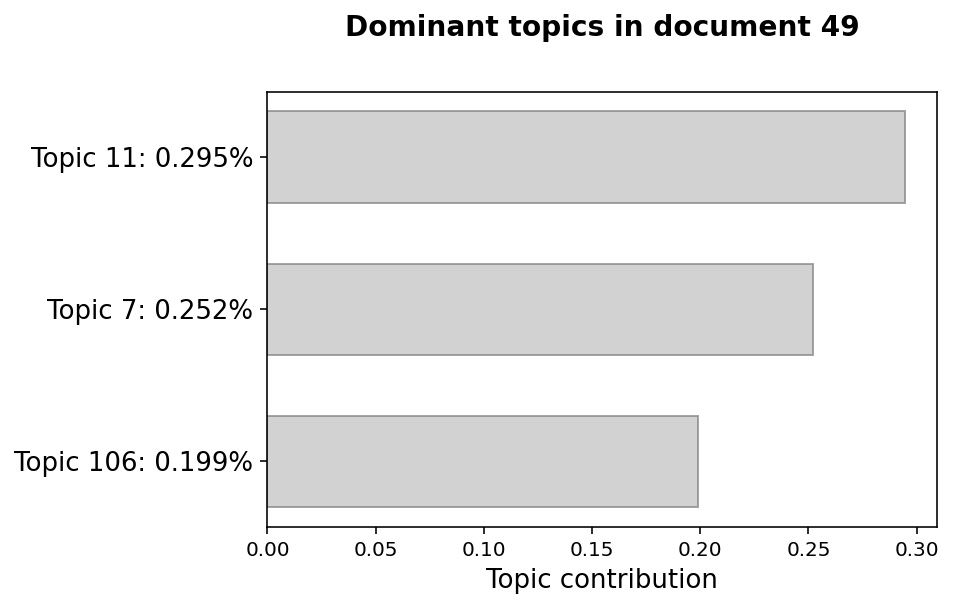

Topic 11
________ 

['0.236*"sport"', '0.155*"club"', '0.142*"réduction_horaire"', '0.134*"travail"', '0.126*"ac"', '0.125*"cadre"', '0.124*"assurance_chômage"', '0.115*"sportif"', '0.104*"sport_populaire"', '0.103*"subvention"', '0.093*"cotisation"', '0.092*"financement_additionnel"', '0.089*"loi"']


Topic 7
_______ 

['0.185*"million_franc"', '0.171*"sport"', '0.156*"rht"', '0.127*"suspension_poursuite"', '0.119*"sportif"', '0.118*"international"', '0.11*"prêt"', '0.103*"club"', '0.093*"liquidité"', '0.09*"subvention"', '0.087*"poursuite"']


Topic 106
_________ 

['0.082*"droit_douane"', '0.077*"start_up"', '0.075*"perte_travail"', '0.071*"actif_niveau"', '0.071*"domaine_migratoire"', '0.07*"masque"', '0.069*"hôpital"', '0.069*"physique"', '0.068*"part"']




In [49]:
# Generate random document index
rnd_idx = random.randint(0,len(df)-1)

# Print top topics in specified document
find_top_topics_in_doc(doc_idx=rnd_idx,df=df,X=X_pca,topics_nbr=3,pca_model=pca,vocab=tfidf_vocab,num_words=18)

## Topic evolution over time

**Let's see now how the proportion of a few selected topics in press releases evolved over time**

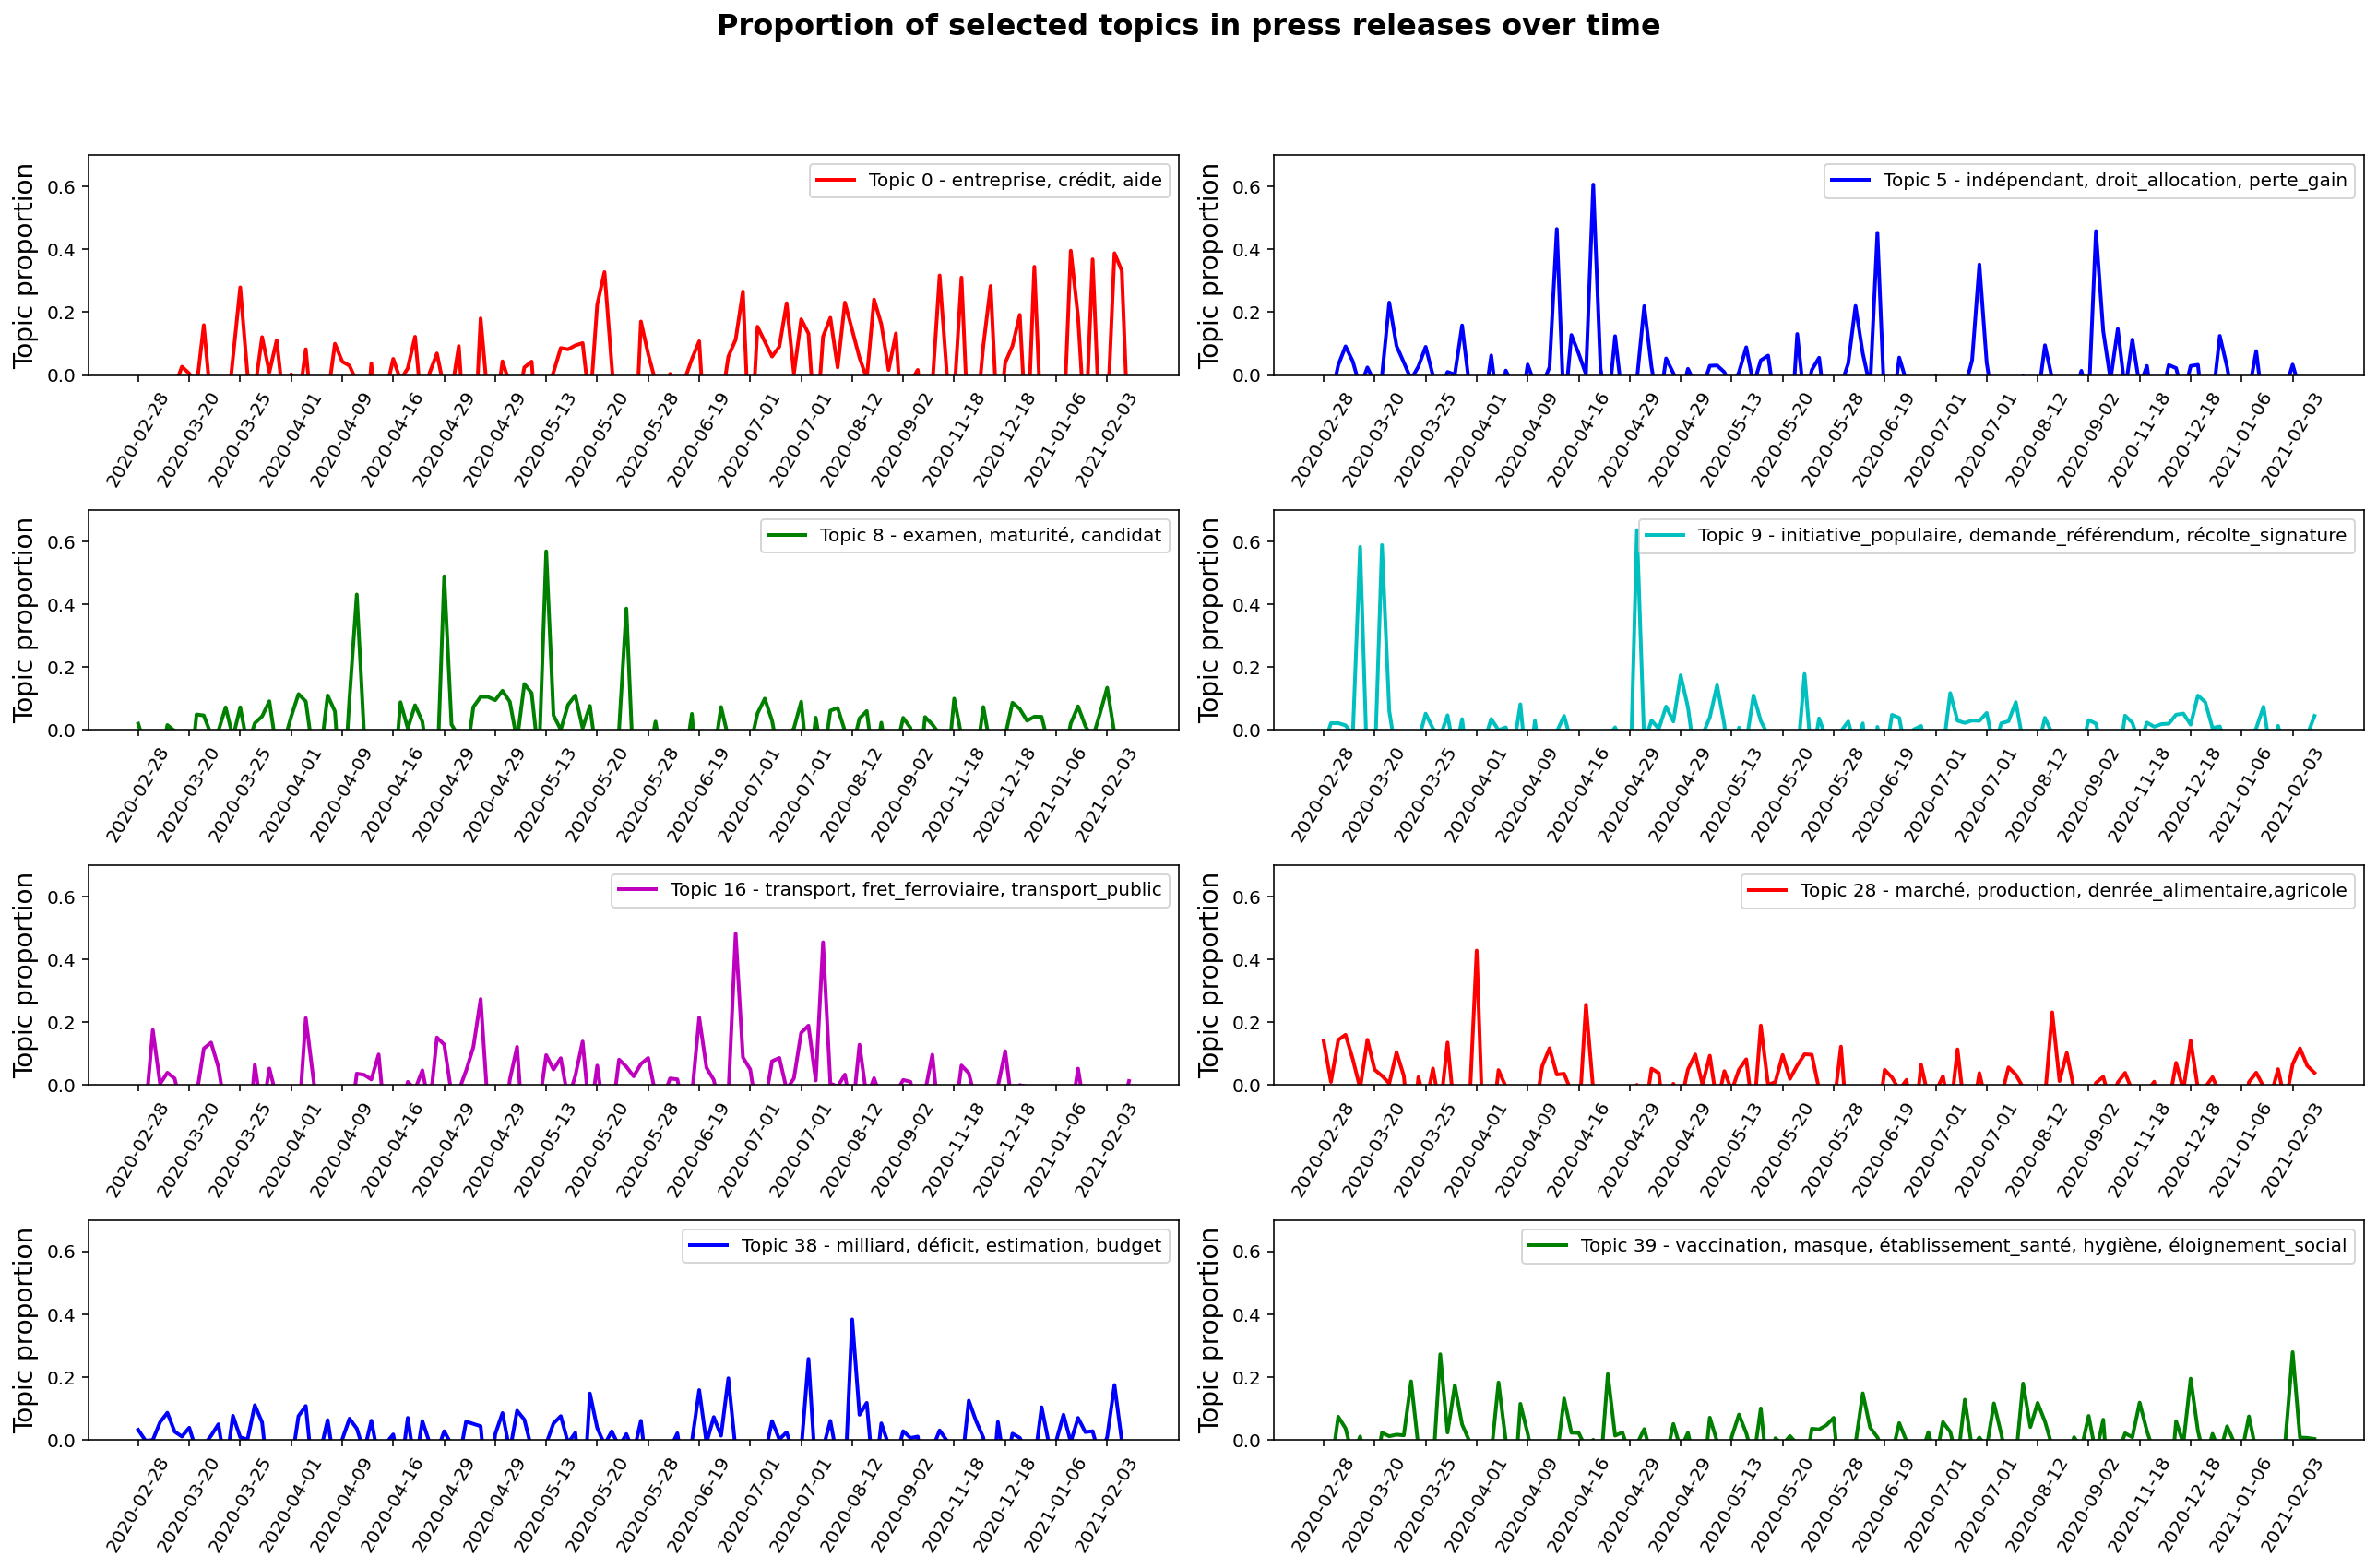

In [33]:
fig, axes = plt.subplots(4,2,figsize=(18,4*2.8))

font_dict_title = {'fontsize':16,'fontweight':'bold'}
font_dict_label = {'fontsize':14}
font_dict_ticks = {'fontsize':10}

label_dict = {'T0' : 'entreprise, crédit, aide',
             'T5'  : 'indépendant, droit_allocation, perte_gain',
             'T8'  : 'examen, maturité, candidat',
             'T9'  : 'initiative_populaire, demande_référendum, récolte_signature',
             'T16' : 'transport, fret_ferroviaire, transport_public',
             'T28' : 'marché, production, denrée_alimentaire,agricole',
             'T38' : 'milliard, déficit, estimation, budget',
             'T39' : 'vaccination, masque, établissement_santé, hygiène, éloignement_social'}

colors = ['r','b','g', 'c', 'm'] * 12

selected_topics = [0, 5, 8, 9, 16, 28, 38, 39]

for c, (i,ax) in enumerate(zip(selected_topics, axes.ravel())): 

    # Empty list
    list_topic = []

    # For every doc
    for j in range(0,X_pca.shape[0]):
        list_topic.append(X_pca[j,i])  # Contribution of i-th topic to j-th document

    ax.plot(list_topic,linewidth=2,color=colors[c], label='Topic {} - {}'.format(str(i),label_dict['T'+str(i)]))

    ax.set_xticks(ticks = np.arange(0,len(df),7))
    ax.set_xticklabels(df.pub_date[0::7],rotation=60,**font_dict_ticks)
    ax.legend() 
    ax.set_ylim([0,0.7])
    ax.set_ylabel('Topic proportion',**font_dict_label)

plt.suptitle('Proportion of selected topics in press releases over time', y=1.05, **font_dict_title);

plt.tight_layout()